# Imports

The **services module** contains functions for accessing third party bioemdical data services.

In [1]:
from services.pdb import pfam, pdbligand, pdbmolecule
from services.classyfire import classyfire
from services.uniprot import pdb2uniprot
from services.uniprot import pdb2uniprotAC
from services.uniprot import entry2ACC
from services.pubchem import get_image
from collections import defaultdict
from tqdm import tqdm
from math import ceil
import pandas as pd

##### PDB
For PDB we have functions for quering information about (1) PDB files, (2) Protein Molecules, (3) Ligands, (4) PFam Annotations and (5) GO annotations.  

##### Uniprot
For Uniprot we query a service that maps pdb IDs to uniprot IDs. 

# Pocket Feature Graph

In [2]:
import pandas as pd
import networkx as nx
import numpy as np

##### Step 1. Convert pocket feature scores to "cosine similarities"

Given a matrix $X \in \mathbb R ^n$ with rows $x_i$, we compute the cosine similarity between two rows as:

$$ \frac{x_i^T x_j}{\lVert x_i \rVert \lVert x_j \rVert }$$

Given symmetric positive semidefinite matrix $A = X X^T$, we can compute cosine similarities using hte formula:

$$\frac{a_{ij}}{\sqrt{a_{ii}}\sqrt{a_{jj}}} = \frac{x_i^T x_j}{\lVert x_i \rVert \lVert x_j \rVert }$$ 

In [51]:
# Read in pocket feature similarities and convert to an adjacency matrix
pf = pd.read_csv('./data/pocket_feature_scores.csv', header=None, names=['pocket_0', 'pocket_1', 'weight'])
pf_matrix = pf.pivot(index='pocket_0', columns='pocket_1', values='weight')

# Compute cosine similarities from pocket feature score matrix
diagonal = np.sqrt(np.diag(-1*pf_matrix))
denominator = np.outer(diagonal, diagonal)
normalized = (-1*pf_matrix)/denominator

##### Step 2. Filter cosine similarities

In order to reduce memory and computational costs, we filter out cosine slimilarity values that fall outside of a range of interest.  For example, we may wish to exclude low similarity values.  Likewise, we do not wish to have self referencing edges in our graph, so we also filter out diagonal values in the adjacency matrix.

In [52]:
# Specify desired range
score_range = [0.6, 0.85]
lower_limit = score_range[0]
upper_limit = score_range[1]

# Set matrix entries out of specificed range to NaN
if lower_limit > 0:
    normalized[normalized < lower_limit] = np.nan
if upper_limit < 1:
    normalized[normalized > upper_limit] = np.nan

# Set off Diagonal to NaN
np.fill_diagonal(normalized.values, np.nan)

#### Steb 2b. Get sequence Similarities

In [53]:
lines = []
for i in range(10):
    new_df = pd.read_csv('seqAlign_' + str(i) +'.csv', index_col=0)
    lines.append(new_df)
seq_align = pd.concat(lines, axis=0)

In [54]:
seq_align_col = seq_align.stack().reset_index()
seq_align_col.columns = ['pocket_0', 'pocket_1', 'align_score']
print(seq_align_col.head())

   pocket_0  pocket_1  align_score
0  4gmg_NAP  4gmg_NAP       1964.0
1  4gmg_NAP  2jah_NDP         47.5
2  4gmg_NAP  5ark_UMP         34.5
3  4gmg_NAP  1oaa_NAP         55.5
4  4gmg_NAP  3plp_BBA         34.0


##### Step 3. Initialize PF Similarity Graph

In [56]:
# Convert from adjacency matrix to edge list
normalized_edges = normalized.stack().reset_index()
normalized_edges = normalized_edges.rename(columns={0:'weight'})

#TRYING TO MERGE the align score with the weights for pf score updates!

#print(seq_align_col.head())
normalized_edges.merge(seq_align_col, how='left', on=['pocket_0', 'pocket_1'])
print(normalized_edges.head())

   pocket_0  pocket_1  align_score
0  4gmg_NAP  4gmg_NAP       1964.0
1  4gmg_NAP  2jah_NDP         47.5
2  4gmg_NAP  5ark_UMP         34.5
3  4gmg_NAP  1oaa_NAP         55.5
4  4gmg_NAP  3plp_BBA         34.0
   pocket_0  pocket_1    weight
0  1w5t_ANP  1w5t_ADP  0.848464
1  1wkl_ATP  1wkl_ADP  0.797754
2  1wnz_2VA  1wk8_VMS  0.756667
3  1xli_GLT  1xid_ASC  0.784545
4  1xp8_AGS  1xmv_ADP  0.673426


In [36]:
# Split off ligand IDs from pocket IDs and add them as separate columns
new = normalized_edges['pocket_0'].str.split("_", expand = True)
normalized_edges['ligand_0'] = new[1]

new = normalized_edges['pocket_1'].str.split("_", expand = True)
normalized_edges['ligand_1'] = new[1]


   pocket_0  pocket_1    weight ligand_0 ligand_1
0  1w5t_ANP  1w5t_ADP  0.848464      ANP      ADP
1  1wkl_ATP  1wkl_ADP  0.797754      ATP      ADP
2  1wnz_2VA  1wk8_VMS  0.756667      2VA      VMS
3  1xli_GLT  1xid_ASC  0.784545      GLT      ASC
4  1xp8_AGS  1xmv_ADP  0.673426      AGS      ADP


In [7]:
# Initialize graph
PFG = nx.Graph()

# Iterate through rows of edge list dataframe
for row in normalized_edges.itertuples():
    
    # If both ligand are the same, do nothing
    ligand_0 = row.ligand_0
    ligand_1 = row.ligand_1
    if ligand_0 == ligand_1:
        continue
        
    # If ligands are different, we pull out pocket IDs and pf cosine similarity
    pocket_0 = row.pocket_0    
    pocket_1 = row.pocket_1
    weight = row.weight
    
    # If we have not seen this pair of ligand before, we add an edge
    if not PFG.has_edge(ligand_0, ligand_1):
        PFG.add_edge(ligand_0, ligand_1, id=[pocket_0, pocket_1], weight=weight)
        
    # Otherise update the edge weight if pf cosine similarity is greater than previous max
    elif weight > PFG[ligand_0][ligand_1]['weight']:
        PFG[ligand_0][ligand_1]['id'] = [pocket_0, pocket_1]
        PFG[ligand_0][ligand_1]['weight'] = weight

## Get Sequence Similarity Scores
### (Not yet normalized)

# Scaffold Hop Scores

We define a scaffold hop score for a pair of ligands as:

$$max\left(\frac{F(m_1, m_2)}{T(m_1,m_2)}\right)$$

Where $m_i$ denotes a ligand in our dataset, $F$ is the pocket feature cosine similarity between bound protein structures, and $T$ is the tanomoto coefficient between chemical fingerprints.  Ligands may be bound in multiple co-crystal structures, and for any pair of ligands there may be a range of scaffold hop scores.  We take the maximum value.  In general, the high scaffold hop scores corrspond to ligands with dissimilar strucutres, that bind slimilar protein pockets.

In [8]:
# Import ligand tanomoto matrix
ligand_matrix = pd.read_csv('./data/ligandComparisons.csv', index_col=0)

In [35]:
SHG = PFG.copy()
for ligand_0, ligand_1 in PFG.edges:
    ligand_score = ligand_matrix[ligand_0][ligand_1]
    pf_score = PFG[ligand_0][ligand_1]['weight']
    
    SHG[ligand_0][ligand_1]['weight'] = pf_score/ligand_score

# Filtering

In [10]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [11]:
from networkx.algorithms import bipartite

def projected_graph(Graph):
    nx.set_node_attributes(Graph, bipartite.color(Graph), name='color')

    top = [i for i in Graph.nodes if Graph.nodes[i]['color'] == 1]
    projected = bipartite.overlap_weighted_projected_graph(Graph, top)
    return projected

all_pockets = []
for u,v in SHG.edges:
    pockets = SHG[u][v]['id']
    all_pockets.extend(pockets)
    
structures, ligands = zip( *[i.split('_') for i in set(all_pockets)] )
structures = list(set(structures))

pdb_uniprot_mapping = pd.read_csv(pdb2uniprot(structures), sep='\t')

PUG = nx.from_pandas_edgelist(pdb_uniprot_mapping, source='From', target='To')
uniprot_filter = projected_graph(PUG)

In [12]:
filtered = SHG.copy()
for u,v in SHG.edges:
    try:
        pdb_0, pdb_1 = [i.split('_')[0] for i in filtered[u][v]['id']]
        if uniprot_filter[pdb_0][pdb_1]['weight'] >= 0.5:
            filtered.remove_edge(u,v)
    except KeyError:
        pass

In [13]:
## Creates dict mapping pdbid to chain containing the binding pocket
header = {0:"pdb", 1:"lig", 2:"chain", 3:"num"}
pdbs = pd.read_csv('./data/PDB_List_Final.txt', header=None, sep='\t')
pdbs = pdbs.rename(columns=header)
pdb_dict = dict(zip(pdbs.pdb, pdbs.chain))

pdb_ligs = pdbs
pdb_ligs['pdb_lig'] = pdbs[['pdb', 'lig']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
pdb_lig_dict  = dict(zip(pdb_ligs.pdb_lig, pdb_ligs.chain))

## Gathering Relationships between PDB + Chain and Uniprot ID

from pprint import pprint
PDB_list = pdb_dict.keys()

count = 0

seqDict = {}
for mol in PDB_list:
    chain_entry = {}
    polymer = pdbmolecule(mol)['polymer'] #Geting data from pdb API
    for j in range(len(polymer)): 
        if type(polymer) == list:
            if type(polymer[j]['chain']) == list: 
                chain = polymer[j]['chain'][0]['id']
            else:
                chain = polymer[j]['chain']['id']
            if 'macroMolecule' in polymer[j]: #Else uniprotACC is empty
                uniprotACC = polymer[j]['macroMolecule']['accession']['id']
            else:
                print('empty uniprot accession')
        else: 
            if type(polymer['chain']) == list: 
                chain = polymer['chain'][0]['id']
            else:
                chain = polymer['chain']['id']
            try:
                uniprotACC = polymer['macroMolecule']['accession']['id']
            except:
                print(mol)
                pprint(pdbmolecule(mol))
                pprint(polymer)
                print(len(polymer))
                count += 1
                print(f"whoopsie! Mistake number {count}")
                
        chain_entry[chain] = uniprotACC
        seqDict[mol] = chain_entry

## Preparing the seq Align Matrix:

pdb_acc = {}
for pdbid in pdb_lig_dict.keys():
    try: 
        pdb_acc[pdbid] = seqDict[pdbid[0:4]][pdb_lig_dict[pdbid]]
    except:
        missing = True

align = pd.read_csv('./data/align_scores.csv', sep=',', index_col='seq1')

id_acc_mapping = pd.read_csv(entry2ACC(align.columns), sep='\t')
id_acc_dict = dict(zip(id_acc_mapping.To, id_acc_mapping.From))

def getID(pdb):
    return acc_id[pdb_acc[pdb]]

seq_align = pd.DataFrame(columns = pdb_lig_dict.keys())
pdb_acc = defaultdict(lambda: 0, pdb_acc)
acc_id = defaultdict(lambda: 0, id_acc_dict)

#update to seq align values. 
pockets = list(pdb_lig_dict.keys())
for i in range(10):
    file = open('seqAlign_' + str(i) +'.csv', 'w+')
    seq_align = pd.DataFrame(columns = pdb_lig_dict.keys())
    
    for j in tqdm(range(ceil(len(pockets)/10*i), ceil(len(pockets)/10*(i+1)))):
        pdb1 = pockets[j]
        seq_align.loc[pdb1] = 0
        seqID1 = acc_id[pdb_acc[pdb1]]
        for pdb2 in pockets:
            seqID2 = acc_id[pdb_acc[pdb2]]

            if seqID1 != 0 and seqID2 != 0:
                seq_align.loc[pdb1, pdb2] = align.loc[seqID1, seqID2]
    file.write(seq_align.to_csv())
    file.close()

In [31]:
lines = []
for i in range(10):
    new_df = pd.read_csv('seqAlign_' + str(i) +'.csv', index_col=0)
    lines.append(new_df)
seq_align = pd.concat(lines, axis=0)
print(seq_align)

          4gmg_NAP  2jah_NDP  5ark_UMP  1oaa_NAP  3plp_BBA  2jc6_QPP  \
4gmg_NAP    1964.0      47.5      34.5      55.5      34.0      50.5   
2jah_NDP      47.5    1213.0      28.5     151.5      27.0      40.5   
5ark_UMP      34.5      28.5     795.0      29.5      45.5      35.5   
1oaa_NAP      55.5     151.5      29.5    1315.0      45.0      38.5   
3plp_BBA      34.0      27.0      45.5      45.0    1303.0      44.0   
...            ...       ...       ...       ...       ...       ...   
2jae_FAD       0.0       0.0       0.0       0.0       0.0       0.0   
3pnb_COA      27.0      42.0      32.0      36.0      25.0      29.5   
4usr_FAD      48.5      52.0      26.5      37.0      36.5      42.5   
4poo_SAM      44.5      47.0      25.0      49.5      49.0      44.0   
1o69_X04      27.5      41.5      41.5      49.0      35.5      66.0   

          3n1t_5GP  2aru_ATP  4rvu_NDP  2vro_NDP  ...  3bpz_CMP  5dld_UD1  \
4gmg_NAP      26.0      29.0      48.5      66.5  ...     

In [32]:
for row in seq_align.index:
    for col in seq_align.index:
        seq_align[row][col] = seq_align[row][col] / max(seq_align[row][row] , seq_align[col][col])
    print(row)
print(seq_align)
        

/Users/allikeys/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


4gmg_NAP
2jah_NDP
5ark_UMP
1oaa_NAP
3plp_BBA
2jc6_QPP
3n1t_5GP
2aru_ATP
4rvu_NDP
2vro_NDP


/Users/allikeys/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/allikeys/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


2vq5_LDP
1aoe_NDP
1aoe_GW3
4i6h_1C8
5mf5_C2E
2fvl_NAP
3ia4_NDP
3ia4_MTX
3rw9_DSH
1a80_NDP
3bqd_DAY
1v8k_ANP
3ry2_BTN
3ez3_ZOL
3ez3_IPE
5cfl_C2E
1txt_CAA
2hw1_ANP
4lsj_LSJ
2xrw_ANP
4eyw_L0R
3g7j_GTX
1q0q_NDP


/Users/allikeys/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


4p5f_AR6
3lst_SAH
1z4r_ACO
1sjw_NGV
3wst_SAH
2xf3_J01
1dhr_NAD
4k7y_FMN
3rl3_5GP
2qo5_CHD
1j1b_ANP
1c9w_NAP
5jy1_NAD
1qrd_FAD
1qrd_CBD
1jf7_TBH
2x3n_FAD
2a0w_DIH
1xve_3BB
2dxe_GDP
4uda_DEX
3bgi_SAH
4kn0_MTX
3r5z_F42
3uf6_COD
1vyr_FMN
4lhw_GNP
3rab_GNP
2v3a_FAD
3nrr_D16
3nrr_UMP
2vd4_P21
2ag5_NAD
5a27_MYA
2agt_NAP
2agt_FID
3bea_IXH
1s16_ANP
3kmt_SAH
4bf2_STU
3iup_NDP
3gx9_FMN
3gx9_TXD
1owl_FAD
4xzj_NAD
1r89_CTP
4dja_FAD
4dja_DLZ
1ixe_COA
2woe_AR6
4je7_BB2
3m6r_BB2
5i2h_AGI
4tnb_SGV
2if8_ADP
4cok_TPP
4at5_MUJ
2pkk_2FA
3tox_NAP
3cly_ACP
3cob_ADP
2ncd_ADP
3au8_NDP
2i1m_5CN
1kbi_FMN
2yaa_ATP
4oxx_FMN
5bz4_COA
4s32_ANP
2p1o_NLA
3vyw_SAM
3ta2_ATP
4s26_SAH
4mo2_FDA
4mo2_FAD
1e4v_AP5
3sff_0DI
2yn8_STU
1kmq_GNP
1pxg_PRF
2nmx_M25
4azh_LOG
5g3t_FDA
4ca6_3EF
2w5a_ADP
1n0u_SO1
3all_FAD
2bmb_PMM
3cth_319
3oad_LPO
4o4f_ATP
1got_GDP
3oa2_NAD
2ek2_SAH
3dr8_ACO
4h2w_5GP
3a8t_ATP
4anm_WUL
2ywl_FAD
3zuy_TCH
1njf_AGS
1njf_ADP
3qfs_FAD
3qfs_NAP
4tx9_AMZ
1lqy_BB2
3qdl_FMN
3ab1_FAD
3vcy_UD1
4mvf_STU
4om8_NAD
2

1f20_NAP
1tz8_DES
2c29_NAP
2c29_DQH
2qxx_TTP
1f0y_CAA
1f0y_NAD
1f3b_GBX
4i9b_NAD
4njo_NAD
4gaa_BES
3i9k_NAD
1xl8_152
1q1g_MTI
3ix3_OHN
2dt5_NAD
4wso_NAD
1maq_PGU
1j39_UPG
4k4p_3TL
3lg5_BTM
3wrb_GDE
5dw0_PLS
2ogi_GDP
4r8q_ADP
5csh_ATP
5ahw_CMP
5ahw_POG
1fp2_SAH
1fp2_HMO
1qsr_ACO
2f59_INI
4itx_IN5
3e4v_FMN
3e7m_H4B
3e7m_AT2
3udz_ADP
2zsc_BTN
1d0l_BLG
3u10_CMP
3iwj_NAD
3u04_BB2
1d2s_DHT
3r6s_CMP
2xjc_5GP
2xjc_B4P
4ivg_ANP
3ko8_NAD
3klb_FMN
1s3z_COA
4r43_GDP
4r57_ACO
4ysw_FAD
4ysw_NAI
4ysw_URC
3be2_RAJ
1sg4_CO8
2wns_OMP
3c96_FAD
4at0_FAD
2y6p_CTP
3fpa_DTB
2wow_FAD
2wow_NDP
1l3i_SAH
3m4h_NAP
3m4h_388
3fri_SAH
1uio_HPR
4cmf_PXG
3m6w_SAM
4aub_NAP
3tm4_SAM
3ou2_SAH
3t64_DU3
2iid_FAD
3c41_ANP
3otw_COA
2wbg_LGS
1yqd_NAP
3t58_FAD
1lke_DOG
2nnq_T4B
4twr_NAD
1pn9_GTX
3mzi_FMN
4qjk_COA
4xcz_FON
4xcz_T3Q
1bp6_UMP
3qj4_FAD
1pno_NAP
1y30_FMN
3h0s_B38
1pl1_ABY
3cui_X4S
2yyu_C5P
3qfa_FAD
3v5l_0G1
4zvy_NAD
2rgo_FAD
2wzv_FMN
1ryd_NDP
3cx8_GSP
4a6d_SAM
2e0a_ANP
4abk_AR6
3o9z_NAD
4zu4_4TG
4a62_ANP
2nv7_555
2

KeyboardInterrupt: 

In [ ]:
file = open('norm_seq_align.csv', 'w+')
file.write(seq_align.to_csv())
file.close()

In [ ]:
seq_len = pd.read_tsv('./data/seq_len.tsv', sep='\t', index_col=0)

# Results

In [15]:
from pprint import pprint

# pprint(sorted(SHG.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10])
# sorted_scores = sorted(SHG.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

pprint(sorted(filtered.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10])
sorted_scores = sorted(filtered.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

[('E3O', 'GEN', {'id': ['2j7y_E3O', '1x7r_GEN'], 'weight': 3.5680618401206634}),
 ('1CY', 'CP6', {'id': ['3um5_CP6', '3irm_1CY'], 'weight': 3.41845238095238}),
 ('GLT', 'ASC', {'id': ['1xli_GLT', '1xid_ASC'], 'weight': 3.3527563527575506}),
 ('E3O', '0L8', {'id': ['4dma_0L8', '2j7y_E3O'], 'weight': 3.0849106955153673}),
 ('TOL', 'TLT', {'id': ['3s3g_TLT', '1zua_TOL'], 'weight': 3.080719586444436}),
 ('EZL', 'E50', {'id': ['3sax_E50', '3mdz_EZL'], 'weight': 2.9597610249579023}),
 ('BYH', '73B', {'id': ['4bjx_73B', '3aqa_BYH'], 'weight': 2.925113299937984}),
 ('ANN', 'MJI', {'id': ['2b96_ANN', '1y6o_MJI'], 'weight': 2.8708386009270965}),
 ('CBE', 'UQ1', {'id': ['2fbw_CBE', '1zoy_UQ1'], 'weight': 2.830621599308954}),
 ('N22', '1CY', {'id': ['3irm_1CY', '3cse_N22'], 'weight': 2.8209424062184887})]


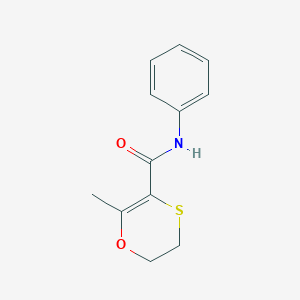

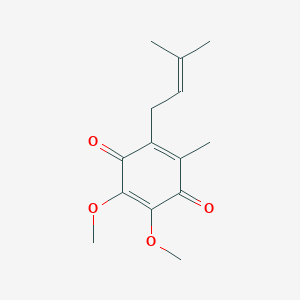

In [16]:
import IPython.display as Disp

# image size can be 'large' or 'small'
image_size = 'large'

# Pick an index of example to inspect 
idx = 8

# everything below pulls info about example
edge = sorted_scores[idx]
lig_0 = edge[0]
lig_1 = edge[1]

lig_info = pdbligand( ','.join([lig_0, lig_1]) )
keys = ['chemicalID','chemicalName', 'formula', 'molecularWeight']
classes = []
for info in lig_info:
    inchi = info['InChIKey']
    co_classes = classyfire(inchi)
    classes.append(co_classes)
    txt = [co_classes['direct_parent']['name'], co_classes['description']]
    image = get_image(inchi, image_size=image_size)
#     url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchi}/PNG?image_size={image_size}' 
#     image = requests.get(url).content
    text = '<br>'.join( [info[key].upper() for key in keys] + txt )
    Disp.display( Disp.Image(image), Disp.HTML(text) )

In [17]:
def extract_pdbids(edge_data):
    pdbs = edge_data['id']
    return ','.join([i.split('_')[0] for i in pdbs])

pprint(pdbmolecule(extract_pdbids(edge[2])))

[{'id': '2FBW',
  'polymer': [{'Taxonomy': {'id': '9031', 'name': 'Gallus gallus'},
               'chain': [{'id': 'A'}, {'id': 'N'}],
               'entityNr': '1',
               'enzClass': {'ec': '1.3.5.1'},
               'length': '621',
               'macroMolecule': {'accession': {'id': 'Q9YHT1'},
                                 'name': 'Succinate dehydrogenase [ubiquinone] '
                                         'flavoprotein subunit, mitochondrial'},
               'polymerDescription': {'description': 'Succinate dehydrogenase '
                                                     'flavoprotein subunit'},
               'type': 'protein',
               'weight': '68256.9'},
              {'Taxonomy': {'id': '9031', 'name': 'Gallus gallus'},
               'chain': [{'id': 'B'}, {'id': 'O'}],
               'entityNr': '2',
               'enzClass': {'ec': '1.3.5.1'},
               'length': '252',
               'macroMolecule': {'accession': {'id': 'Q9YHT2'},
     